# Identification of Deepfaked Images (and Videos?)
## By Li Run & Rongyi

## Problem Statement

Within the past year, deepfaked media has risen to prominence all over the world. With it being near-impossible to differentiate between real and fake online nowadays, how can we help the average person tell what is real?

Thus the question arises: **Given an image, is it possible to tell if it is deepfaked or not?**

In this project, our aim is to develop an AI model that is capable of **identifying deepfaked images with ≥70% accuracy.**


## Data Collection

We utilized two datasets of images for training our model:
1. https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
2. https://www.kaggle.com/datasets/dagnelies/deepfake-faces

The first dataset contains approximately 70,000 training images, 5400 test images and 20,000 validation images of faces for both Real and Fake images each.

The second dataset contains approximately 95,600 images of faces. Labelling of the images as real or fake can be found under `metadata.csv`.

## Data Preprocessing

Let us first inspect the contents of `deepfake_faces`.

In [20]:
# import os
# os.remove('/kaggle/working/output-models/best_model.keras')

In [ ]:
# Uncomment line below to install tensorflow with cuda 
# !pip install tensorflow[and-cuda] --target=/kaggle/working/cuda-files/tensorflow

In [1]:
# Imports

import sys
sys.path.append('/kaggle/working/cuda-files/tensorflow')  # Add the directory to sys.path



import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
from sklearn.utils.class_weight import compute_class_weight
import os, os.path, shutil
from tqdm import tqdm
import cv2
import keras

2024-04-06 12:28:46.375406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 12:28:46.375532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 12:28:46.541503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
df = pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')
df.head()

In [ ]:
df[df.videoname == 'aaagqkcdis.mp4']

We took the name of the first image `aaaqgkcdis.jpg` and looked it up in`metadata.csv`, confirming that the image names corresponded to entries within the csv file allowing us to label the images ourselves.

In [ ]:
df['label'].value_counts()

From here we can see that the Fake:Real ratio in `deepfake_faces` is about 5:1. We need to handle this class imbalance in our data, which we will do by just taking a sample of 16,000 images from each Fake and Real instead. We also needs to categorise the images since they have not been labelled in the same format as in `deepfake-and-real-images`.


In [ ]:
# NOTE: Run if output working folder is still empty

FOLDER_PATH = '/kaggle/input/deepfake-faces/faces_224/'
FAKE_PATH = '/kaggle/working/deepfake-faces/Fake'
REAL_PATH = '/kaggle/working/deepfake-faces/Real'

os.makedirs(FAKE_PATH, exist_ok=True)
os.makedirs(REAL_PATH, exist_ok=True)   

realcount = 0
fakecount = 0
for index, row in tqdm(df.iterrows()):
    img_name = row['videoname'].split('.')[0] + '.jpg'
    old_path = FOLDER_PATH + img_name
    if row['label'] == 'REAL':
        if realcount < 16000:
            new_path = os.path.join(REAL_PATH', img_name)
            realcount += 1
        else:
            continue

    else:
        if fakecount < 16000:
            new_path = os.path.join(FAKE_PATH, img_name)
            fakecount += 1
        else:
            continue
    
    shutil.copy(old_path, new_path)

    
print("Categorisation complete")
        

Let us test if our categorisation worked.

In [ ]:
plt.figure(figsize=(15,15))
file_names = os.listdir(FAKE_PATH + '/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread(os.path.join(FAKE_PATH, file_names[idx]))
    # Redundant but i want to test if any real images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
file_names = os.listdir(REAL_PATH + '/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread(os.path.join(REAL_PATH, file_names[idx])))
    # Redundant but i want to test if any fake images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

As we can see from above, we have successfully separated the image files into 2 different subdirectories, `deepfake-faces/Real` and `deepfake-faces/Fake`.

Next, we will organize the data into their appropriate categories before splitting them into training and test/validation data.

This is achieved by splitting the images from `deepfake_and_real_images` into their training/validation/test sets first since those have already been organised for us, then adding on the images from `deepfake_faces`.

In [2]:
TRAIN_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
VAL_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
TEST_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Test'


TRAIN_DATASET_SIZE = 40000
VAL_DATASET_SIZE = 10000
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH, 
    labels='inferred',
#     label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=True
)
val = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    labels='inferred',
#     label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=True
)
test =  tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    labels='inferred',
#     label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=1,
    color_mode='rgb',
    shuffle=False
)


## Code for taking a sample of dataset

print(train.class_names)




train.shuffle(len(train), reshuffle_each_iteration=False)
print(f'Pre-sampling train: {len(train)*BATCH_SIZE}')
train = train.take(TRAIN_DATASET_SIZE//BATCH_SIZE)
train = train.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
print(f'Post-sampling train: {len(train)*BATCH_SIZE}')

val.shuffle(len(val), reshuffle_each_iteration=False)
print(f'Pre-sampling val: {len(val)*BATCH_SIZE}')
val = val.take(VAL_DATASET_SIZE//BATCH_SIZE)
print(f'Post-sampling val: {len(val)*BATCH_SIZE}')
print("Sampling complete")

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
['Fake', 'Real']
Pre-sampling train: 140032
Post-sampling train: 40000
Pre-sampling val: 39456
Post-sampling val: 9984
Sampling complete


Code for separating into real and fake to get equal amts (FAILED LOL)

In [3]:
# REAL_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Train/Real'
# FAKE_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Train/Fake'
# train_real = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_PATH, 
#     labels='inferred', 
#     class_names=['Real'],
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )


# train_fake = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_PATH, 
#     labels='inferred', 
#     class_names=['Fake'],
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

# print(train_real.class_names, train_fake.class_names)

# train_real.shuffle(len(train_real), reshuffle_each_iteration=False)
# train_fake.shuffle(len(train_fake), reshuffle_each_iteration=False)
# train_real = train_real.take(TRAIN_DATASET_SIZE//BATCH_SIZE)
# train_fake = train_fake.take(TRAIN_DATASET_SIZE//BATCH_SIZE)
# train = train_real.concatenate(train_fake)

In [ ]:
deepfake_faces = tf.keras.utils.image_dataset_from_directory('/kaggle/working/deepfake-faces', labels='inferred', image_size=(224,224),)

print(deepfake_faces.class_names)



In [ ]:
deepfake_faces = deepfake_faces.shuffle(10, reshuffle_each_iteration=True)

train_size = int(0.7 * len(deepfake_faces))
test_size = int(0.15 * len(deepfake_faces))
val_size = int(0.15 * len(deepfake_faces))

train2 = deepfake_faces.take(train_size)
test2 = deepfake_faces.skip(train_size)
val2 = test2.skip(val_size)
test2 = test2.take(test_size)

train_merged = train.concatenate(train2)
val_merged = val.concatenate(val2)
test_merged = test.concatenate(test2)

# print(train_merged.class_names)
print(len(train_merged), len(train), len(train2))
print(len(train_merged), len(val_merged), len(test_merged))

We are now done with merging our datasets, and can move on to training our model.

## Training of Model

### Implementation of Rescaling, Data Augmentation & Callbacks

In [4]:
#Rescaling and Resizing
rescale_and_resize = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.Rescaling(1./255)
])

In [5]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(0.2),
])

In [6]:

from tensorflow.keras.callbacks import EarlyStopping

# class CustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy') >= 0.75):
#       print("Accuracy>=75%. Cancelling training.")
# acc_limit_callback = CustomCallback()


earlystop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1
)


CHECKPOINT_PATH = '/kaggle/working/output-models/best_model.model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
#     save_weights_only=True
)


# callback_list = [earlystop_callback, checkpoint_callback]
callback_list = [checkpoint_callback]

### Custom functions for testing model

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def produce_cm(model, test_dataset):
    
    true_labels = []
    for images, labels in test_dataset.unbatch().batch(1):
        true_labels.append(labels.numpy())

    test_labels = np.array(true_labels).flatten()

    predictions = model.predict(test_dataset)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_labels  # Assuming you have these


    print(classification_report(true_classes, predicted_classes))
    
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [8]:
def test_accuracy(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    print("Test Accuracy:", accuracy)
    print("Test Loss:", loss)
    

In [9]:
def chart_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['accuracy', 'val_accuracy'], loc='upper left')
    
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['loss', 'val_loss'], loc='upper left')
    
    
    plt.show()
    

In [10]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
    img = keras.preprocessing.image.load_img(filename, target_size = (224, 224))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    return img

def test_image(model, filename):
    image = load(filename)
    logits = model.predict(image)
    probabilities = np.exp(logits) / np.sum(np.exp(logits))
    print(f'Logits: {logits}')
    print(f'Probabilities: {probabilities}')
    

### Model implementation

### Trying to implement our own CNN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    
    tf.keras.layers.Conv2D(32, kernel_size=5, activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=5,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), #there are 2 different classes 
])


model.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=callback_list
)

In [ ]:
test_accuracy(model, test)

In [ ]:
produce_cm(model, test)

For our testing, we handpick a few images from either the test dataset or images that have never been introduced before (sourced online).

In [ ]:
test_image(model, '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_412.jpg')

In [ ]:
test_image(model, '/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake/fake_1004.jpg')


### Stolen from https://www.semanticscholar.org/paper/Fake-Faces-Identification-via-Convolutional-Neural-Mo-Chen/65f96431077b7a4cfb999fbe8fc68db73ab80077

In [11]:
model2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,
    
    
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=(1,1), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(1,1), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(1,1), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.Dense(2, activation='softmax'), #there are 2 different classes 
    

])


model2.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [12]:
history2 = model2.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 196s 126ms/step - accuracy: 0.6422 - loss: 0.6674 - val_accuracy: 0.7592 - val_loss: 0.4874
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.7865 - loss: 0.4472 - val_accuracy: 0.8150 - val_loss: 0.3996
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.8506 - loss: 0.3388 - val_accuracy: 0.8489 - val_loss: 0.3503
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.8710 - loss: 0.2983 - val_accuracy: 0.8475 - val_loss: 0.3321
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - accuracy: 0.8865 - loss: 0.2666 - val_accuracy: 0.8703 - val_loss: 0.3034
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - accuracy: 0.9011 - loss: 0.2329 - val_accuracy: 0.8821 - val_loss: 0.2872
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.8870 - loss: 0.2705 - val_accuracy: 0.7051 - val_loss: 0.5652
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 111ms/step - ac

10905/10905 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.8606 - loss: 0.3301
Test Accuracy: 0.8378725647926331
Test Loss: 0.3848828375339508
10905/10905 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      5492
           1       0.86      0.81      0.83      5413

    accuracy                           0.84     10905
   macro avg       0.84      0.84      0.84     10905
weighted avg       0.84      0.84      0.84     10905



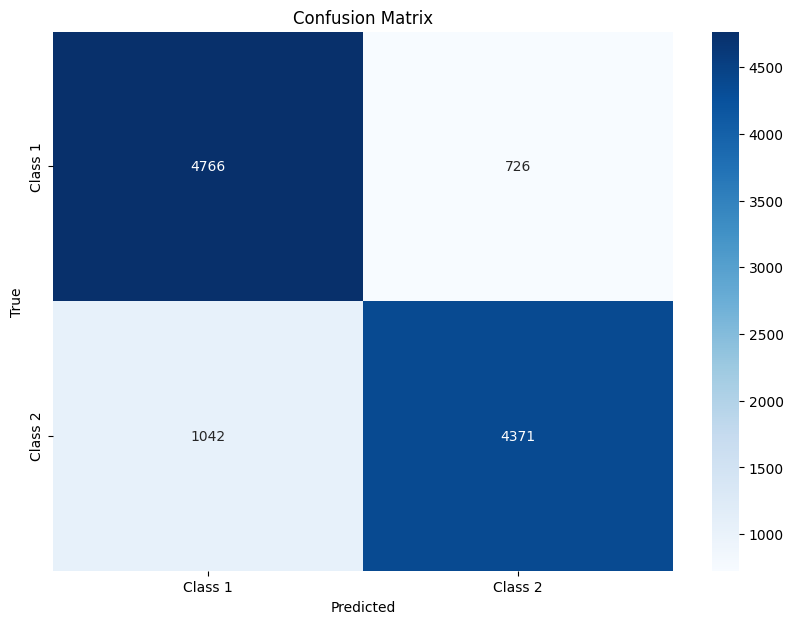

In [14]:
MODEL_PATH = '/kaggle/working/output-models/best_model.weights.h5'
model2.load_weights(MODEL_PATH)

test_accuracy(model2, test)
produce_cm(model2, test)

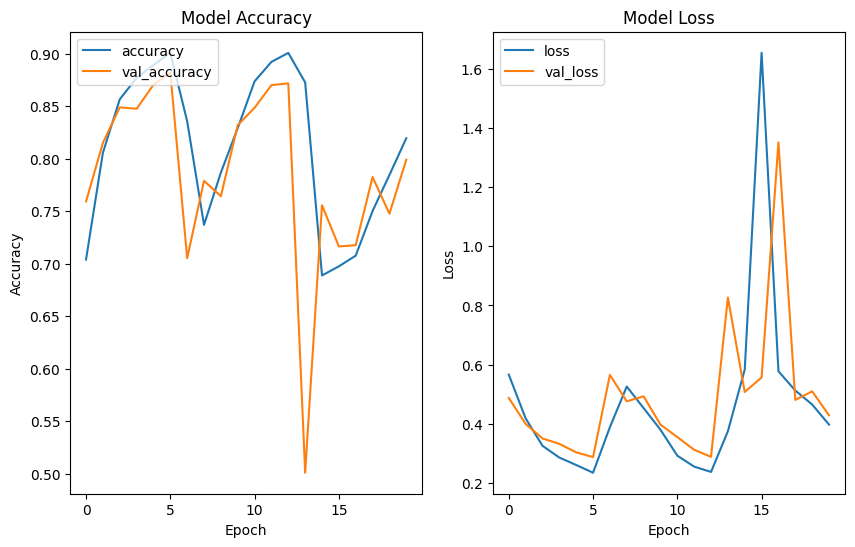

In [15]:
chart_history(history2)

Let us try to get a higher accuracy be reducing our learning rate as it seems to be overfitting after epoch 5.

In [53]:
model3 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,
    
    
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=(1,1), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(1,1), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(1,1), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.Dense(2, activation='softmax'), #there are 2 different classes 
    

])


model3.compile(optimizer=tf._optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [54]:
history3 = model3.fit(
    train,
    validation_data=val,
    epochs=30,
    callbacks=callback_list
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 112ms/step - accuracy: 0.6667 - loss: 0.6273 - val_accuracy: 0.7719 - val_loss: 0.4758
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.7955 - loss: 0.4326 - val_accuracy: 0.7840 - val_loss: 0.4597
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.8581 - loss: 0.3238 - val_accuracy: 0.8611 - val_loss: 0.3207
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.8876 - loss: 0.2683 - val_accuracy: 0.8493 - val_loss: 0.3127
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.8988 - loss: 0.2390 - val_accuracy: 0.8801 - val_loss: 0.2810
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.9142 - loss: 0.2092 - val_accuracy: 0.8680 - val_loss: 0.2971
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - accuracy: 0.9241 - loss: 0.1854 - val_accuracy: 0.8913 - val_loss: 0.2490
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 152s 121ms/step - ac

10905/10905 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8606 - loss: 0.3301
Test Accuracy: 0.8378725647926331
Test Loss: 0.3848828375339508
10905/10905 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      5492
           1       0.86      0.81      0.83      5413

    accuracy                           0.84     10905
   macro avg       0.84      0.84      0.84     10905
weighted avg       0.84      0.84      0.84     10905



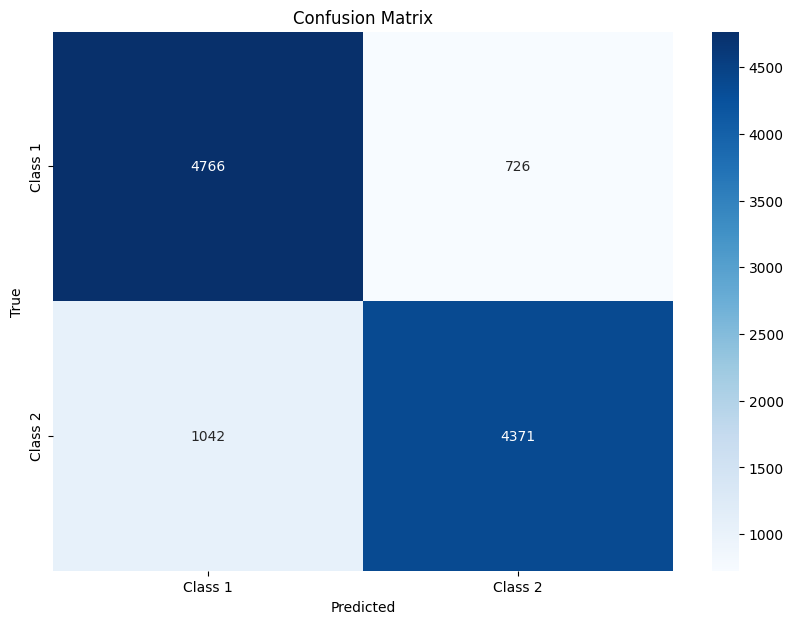

In [55]:
MODEL_PATH = '/kaggle/working/output-models/best_model.weights.h5'
model3.load_weights(MODEL_PATH)

test_accuracy(model3, test)
produce_cm(model3, test)

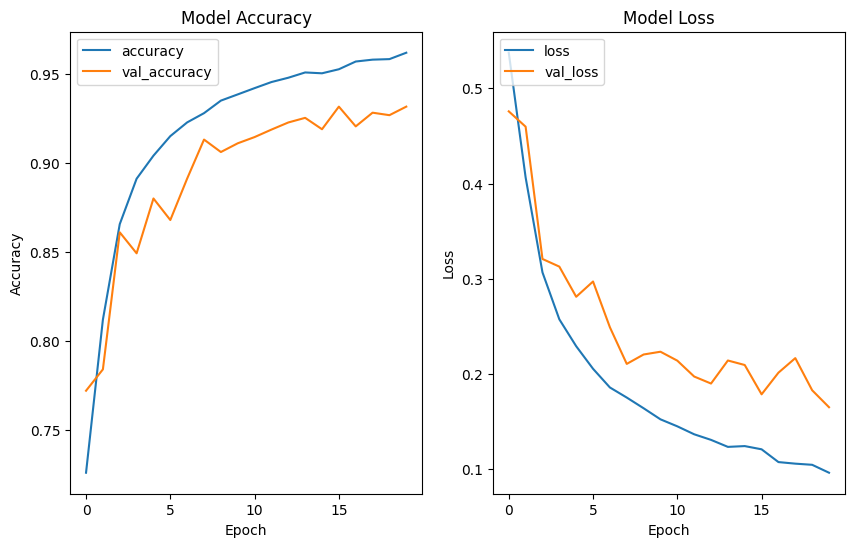

In [56]:
chart_history(history3)

Since we seem to be getting >80% accuracy on our test dataset, let us try with some images that we sourced online.

Before that, we will test to see how the classes in our softmax are outputted. Based on `train.class_names` that we ran earlier, it should be ["Fake", "Real"].

In [28]:
test_path_real = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/'

predictions = [0, 0]
for i in tqdm(range(1000,2000)):
    actual_path = test_path_real + 'real_' + str(i) + '.jpg'
    image = load(actual_path)
    logits = model2.predict(image, verbose=0)
    probabilities = np.exp(logits) / np.sum(np.exp(logits))
    predictions[np.argmax(probabilities)] += 1

print(predictions)
print("Index " + str(np.argmax(predictions)) + " on softmax output = Real" )

100%|██████████| 1000/1000 [01:07<00:00, 14.79it/s]

[170, 830]
Index 1 on softmax output = Real


We can see that the outputs are indeed in the format of ["Fake", "Real"]

In [52]:
test_path_real = '/kaggle/input/deepfake-test/'

predictions = {'Correct': 0, 'Wrong': 0}
for i in range(1,7):
    for j in ['Fake', 'Real']:
        actual_path = f'{test_path_real}Image{str(i)}_{j}.png'
        image = load(actual_path)
        logits = model2.predict(image, verbose=0)
        probabilities = np.exp(logits) / np.sum(np.exp(logits))
        prediction = ['Fake', 'Real'][np.argmax(probabilities)]
        prediction_status = "Correct" if j == prediction else "Wrong"
        predictions[prediction_status] += 1
        
        print(f'{j} Image {i} is {prediction} - {prediction_status}')
    
    

print(predictions)
acc = np.round(predictions['Correct'] / (predictions['Correct'] + predictions['Wrong']) * 100, 2)
print(f'Our Model has a {acc}% accuracy on our test images.')


Fake Image 1 is Fake - Correct
Real Image 1 is Real - Correct
Fake Image 2 is Real - Wrong
Real Image 2 is Real - Correct
Fake Image 3 is Fake - Correct
Real Image 3 is Fake - Wrong
Fake Image 4 is Fake - Correct
Real Image 4 is Fake - Wrong
Fake Image 5 is Real - Wrong
Real Image 5 is Real - Correct
Fake Image 6 is Real - Wrong
Real Image 6 is Real - Correct
{'Correct': 7, 'Wrong': 5}
Our Model has a 58.33% accuracy on our test images.


### Trying InceptionV3 with `deepfake-and-real-images` dataset only

In [37]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_preprocessed = train.map(preprocess)
val_preprocessed = val.map(preprocess)
test_preprocessed = test.map(preprocess)

print("Preprocessing complete")

Preprocessing complete


In [38]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model_inception = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), 
])


In [39]:
model_inception.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [40]:
history_real = model_inception.fit(
    train_preprocessed,
    validation_data=val_preprocessed,
    epochs=10
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 154s 114ms/step - accuracy: 0.5134 - loss: 0.9617 - val_accuracy: 0.5005 - val_loss: 0.6932
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 113ms/step - accuracy: 0.4994 - loss: 0.6934 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.5002 - loss: 0.6936 - val_accuracy: 0.4994 - val_loss: 0.6932
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.4988 - val_loss: 0.6931
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 112ms/step - accuracy: 0.4983 - loss: 0.6932 - val_accuracy: 0.5007 - val_loss: 0.6932
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.5025 - loss: 0.6934 - val_accuracy: 0.4992 - val_loss: 0.6934
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 112ms/step - accuracy: 0.5039 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - ac

In [41]:
test_accuracy(model_inception, test_preprocessed)

10905/10905 ━━━━━━━━━━━━━━━━━━━━ 168s 15ms/step - accuracy: 0.8490 - loss: 0.6912
Test Accuracy: 0.5036221742630005
Test Loss: 0.6930974125862122


10905/10905 ━━━━━━━━━━━━━━━━━━━━ 134s 12ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5492
           1       0.00      0.00      0.00      5413

    accuracy                           0.50     10905
   macro avg       0.25      0.50      0.33     10905
weighted avg       0.25      0.50      0.34     10905



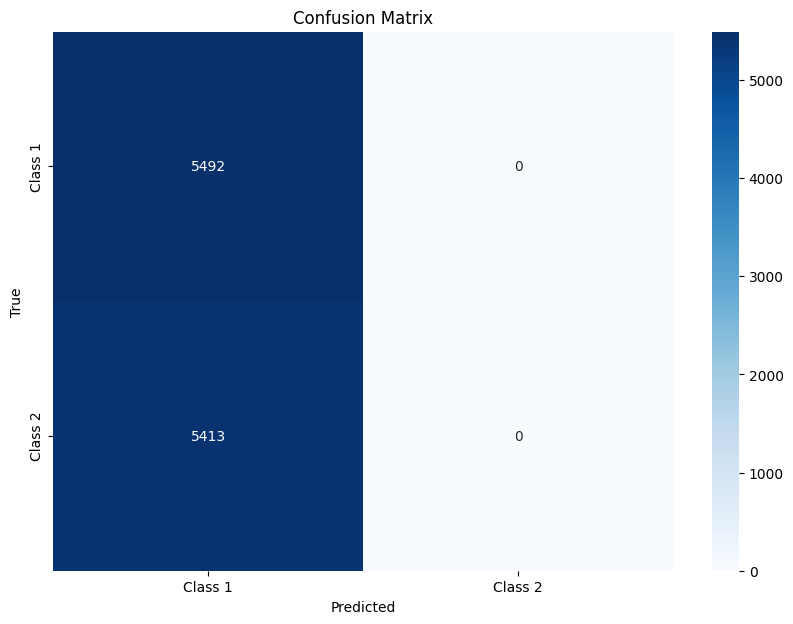

In [42]:
produce_cm(model_inception, test_preprocessed)

We observe that the current model is overfitting. Hence we perform hyperparameter tuning.

First we decrease the learning rate of our model to see if it will obtain a higher accuracy.


In [ ]:
model_inception_lr = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), #there are 2 different classes 
])

In [ ]:
model_inception_lr.compile(optimizer=tf._optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
history_lr_modified = model_inception_lr.fit(
    train_preprocessed,
    validation_data=val_preprocessed,
    epochs=10
)

In [ ]:
test_accuracy(model_inception_lr, test_preprocessed) 

In [ ]:
produce_cm(model_inception_lr, test_preprocessed)

In [ ]:
model_inception_dense = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), #there are 2 different classes 
])

In [ ]:
model_inception_dense.compile(optimizer=tf._optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
)

In [ ]:
history_dense_modified = model_inception_dense.fit(
    train_preprocessed,
    validation_data=val_preprocessed,
    epochs=10
)

In [ ]:
test_accuracy(model_inception_dense, test_preprocessed) 

In [ ]:
produce_cm(model_inception_dense, test_preprocessed)

### Trying InceptionV3 with merged dataset

In [ ]:
train_merged_preprocessed = train_merged.map(preprocess)
val_merged_prerocessed = val_merged.map(preprocess)
test_merged_preprocessed = test_merged.map(preprocess)

In [ ]:
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model2.trainable = False

model_inception2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), #there are 2 different classes 
])


In [ ]:
history_inception2 = model_inception2.fit(
    train_merged_preprocessed,
    validation_data=val_merged_preprocessed,
    epochs=10,
)

In [ ]:
test_accuracy(model_inception2, test_merged_preprocessed)

### Trying ResNet model

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
base_model_resnet.trainable = False

model_resnet = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model_resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


model_resnet.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
history_resnet = model_resnet.fit(
    train_merged,
    validation_data=val_merged,
    epochs=10,
)

In [ ]:
loss_resnet, accuracy_resnet = model_resnet.evaluate(test_merged)
print("Test accuracy:", accuracy_resnet)

### Trying EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

efficient_net = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in efficient_net.layers:
    layer.trainable = False


model_efficient = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    efficient_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), 
])

model_efficient.summary()
model_efficient.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
history_efficient = model_efficient.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=callback_list
)

In [ ]:
produce_cm(model_efficient, test)